In [14]:
import matplotlib.pyplot as plt
import seaborn as sns;sns.set_style();
import numpy as np
from sklearn.linear_model import LinearRegression


In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

# ==========================================
# 1. The Raw Data (Input Space)
# ==========================================
# Let's create 5 houses: [Bathrooms, Rooms]
# y = Price (in $1000s)
X_raw = np.array([
    [1, 3],  # Small house
    [2, 3],  # Weird house: Many baths, few rooms (diminishing return?)
    [2, 4],  # Standard family home
    [3, 5],  # Large home
    [4, 8]   # Mansion
])

# Let's say the true price logic has a synergy: Rooms * Baths is valuable.
y = np.array([150, 200, 300, 550, 900])

# ==========================================
# 2. The Basis Function (Feature Extractor)
# ==========================================
def polynomial_basis_transform(X, degree=2):
    """
    Manually transforms input X (N x D) into Feature Space Phi (N x M).
    We limit this to Degree 2 for clarity.
    """
    N, D = X.shape
    
    # We will build a list of rows, then convert to numpy array
    phi_list = []
    
    feature_names = [] # To keep track of what we built
    
    for i in range(N):
        # Extract the raw vector for this house
        x_vec = X[i]
        baths = x_vec[0]
        rooms = x_vec[1]
        
        # --- The Basis Construction ---
        row = []
        
        # 1. Bias Term (phi_0 = 1)
        row.append(1.0)
        if i == 0: feature_names.append("Bias (1)")
        
        # 2. Linear Terms (phi_1, phi_2)
        row.append(baths)
        row.append(rooms)
        if i == 0: feature_names.extend(["Baths", "Rooms"])
        
        # 3. Squared Terms (Curvature)
        row.append(baths ** 2)
        row.append(rooms ** 2)
        if i == 0: feature_names.extend(["Baths^2", "Rooms^2"])
        
        # 4. Interaction Term (Synergy)
        # This is the "Smart" feature
        row.append(baths * rooms)
        if i == 0: feature_names.append("Baths * Rooms")
        
        phi_list.append(row)
        
    return np.array(phi_list), feature_names

# Apply the transformation
Phi, names = polynomial_basis_transform(X_raw)

print("--- Step 1: Raw Input (First House) ---")
print(f"Raw: {X_raw[0]}") # [1, 3]

print("\n--- Step 2: Transformed Feature Space (First House) ---")
print(f"Features: {names}")
print(f"Values:   {Phi[0]}") 
# Notice: Values are [1., 1., 3., 1., 9., 3.]
# The last value '3' is 1*3 (Interaction)

# ==========================================
# 3. The Model (Scikit-Learn)
# ==========================================
# We fit on Phi, NOT X_raw
model = LinearRegression(fit_intercept=False) # We already added the '1' column manually!
model.fit(Phi, y)


print("\n--- Step 3: Learned Weights (The 'Sliders') ---")
for name, weight in zip(names, model.coef_):
    print(f"{name:15} : {weight:.2f}")

# Example Prediction
print("\n--- Step 4: Prediction for a new house [3 baths, 6 rooms] ---")
x_new = np.array([[3, 6]])
phi_new, _ = polynomial_basis_transform(x_new)
price_pred = model.predict(phi_new)
print(f"Predicted Price: ${price_pred[0]:.2f}k")

--- Step 1: Raw Input (First House) ---
Raw: [1 3]

--- Step 2: Transformed Feature Space (First House) ---
Features: ['Bias (1)', 'Baths', 'Rooms', 'Baths^2', 'Rooms^2', 'Baths * Rooms']
Values:   [1. 1. 3. 1. 9. 3.]

--- Step 3: Learned Weights (The 'Sliders') ---
Bias (1)        : -180.90
Baths           : -189.33
Rooms           : 200.00
Baths^2         : 25.56
Rooms^2         : -29.78
Baths * Rooms   : 54.21

--- Step 4: Prediction for a new house [3 baths, 6 rooms] ---
Predicted Price: $585.11k


In [22]:
x = np.linspace(0, 25, 10)

In [23]:
x

array([ 0.        ,  2.77777778,  5.55555556,  8.33333333, 11.11111111,
       13.88888889, 16.66666667, 19.44444444, 22.22222222, 25.        ])

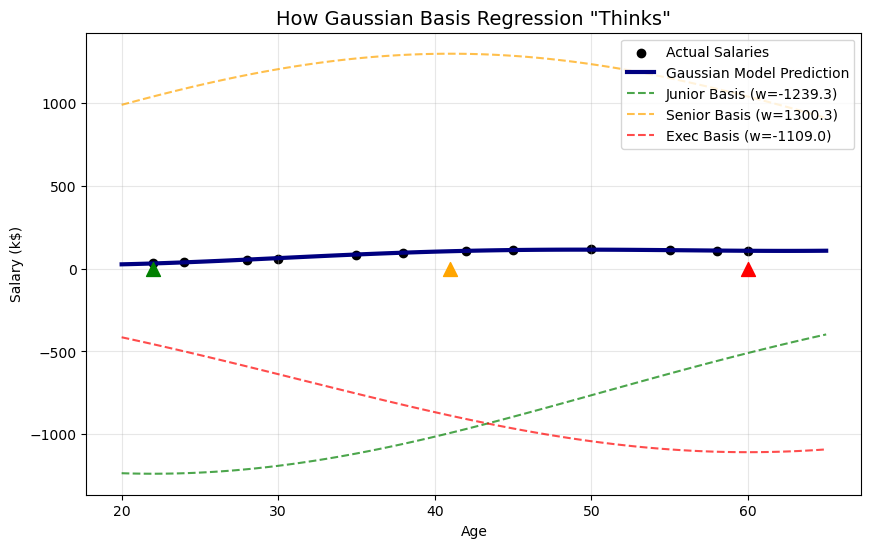

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline

# ==========================================
# 1. The Expert Class (Custom Transformer)
# ==========================================
class GaussianFeatures(BaseEstimator, TransformerMixin):
    """
    Uniformly spaced Gaussian Basis functions.
    This acts as a 'Feature Extractor' in a sklearn pipeline.
    """
    def __init__(self, n_centers=5, width_scale=1.0):
        self.n_centers = n_centers
        self.width_scale = width_scale
        self.centers_ = None
        self.width_ = None

    def fit(self, X, y=None):
        # Create centers spread uniformly across the input range
        # Note: X is expected to be (N, 1)
        min_val = X.min()
        max_val = X.max()
        self.centers_ = np.linspace(min_val, max_val, self.n_centers)
        
        # Heuristic for width: spread / (n_centers - 1)
        # We multiply by width_scale to control overlap
        self.width_ = (max_val - min_val) / (self.n_centers - 1) * self.width_scale
        return self

    def transform(self, X):
        # Calculate distance to each center
        # Result shape: (N_samples, n_centers)
        phi = np.zeros((X.shape[0], self.n_centers))
        
        for i, center in enumerate(self.centers_):
            # The RBF Formula: exp( - ||x - mu||^2 / 2s^2 )
            phi[:, i] = np.exp(-(X.ravel() - center)**2 / (2 * self.width_**2))
            
        return phi

# ==========================================
# 2. The Data (Age vs Salary)
# ==========================================
# Ages 22 to 60
X_train = np.array([22, 24, 28, 30, 35, 38, 42, 45, 50, 55, 58, 60]).reshape(-1, 1)
# Salaries (k$) with a non-linear trend (rise then plateau)
y_train = np.array([35, 40, 55, 60, 85, 95, 110, 115, 118, 115, 110, 105])

# ==========================================
# 3. The Pipeline (Feature Extraction + Model)
# ==========================================
# We create a pipeline: Raw Data -> Gaussian Features -> Linear Regression
# We use 3 Centers (Junior, Senior, Exec) and a width scale of 1.0
model = make_pipeline(GaussianFeatures(n_centers=3, width_scale=1.5), 
                      LinearRegression())

model.fit(X_train, y_train)

# ==========================================
# 4. Visualization
# ==========================================
X_plot = np.linspace(20, 65, 100).reshape(-1, 1)
y_pred = model.predict(X_plot)

# Access the steps to peek "under the hood"
gaussian_transformer = model.named_steps['gaussianfeatures']
linear_regressor = model.named_steps['linearregression']
centers = gaussian_transformer.centers_
weights = linear_regressor.coef_
intercept = linear_regressor.intercept_

# Plotting
plt.figure(figsize=(10, 6))

# A. Plot the Data and Final Prediction
plt.scatter(X_train, y_train, color='black', label='Actual Salaries')
plt.plot(X_plot, y_pred, color='navy', linewidth=3, label='Gaussian Model Prediction')

# B. Plot the "Prototypes" (The underlying basis functions)
# We calculate the raw basis functions for the plot grid
phi_plot = gaussian_transformer.transform(X_plot)

# Plot each weighted basis function to show how they sum up
colors = ['green', 'orange', 'red']
labels = ['Junior Basis', 'Senior Basis', 'Exec Basis']

for i in range(len(centers)):
    # Calculate the contribution: Weight * Basis_Function + (Intercept/3 for viz)
    contribution = (weights[i] * phi_plot[:, i]) 
    
    # We add a baseline just for visualization clarity
    plt.plot(X_plot, contribution, linestyle='--', color=colors[i], alpha=0.7, 
             label=f'{labels[i]} (w={weights[i]:.1f})')
    
    # Mark the center
    plt.scatter([centers[i]], [0], marker='^', s=100, color=colors[i], zorder=10)

plt.title('How Gaussian Basis Regression "Thinks"', fontsize=14)
plt.xlabel('Age')
plt.ylabel('Salary (k$)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()